## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [ ]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random
import os

import sinogap_module_128_64 as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223
sg.plt.rcParams['axes.spines.left'] = False
sg.plt.rcParams['axes.spines.right'] = False
sg.plt.rcParams['axes.spines.top'] = False
sg.plt.rcParams['axes.spines.bottom'] = False




### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 1
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**12
    ,batchSplit = 2**0
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateG = 1e-3
    ,learningRateD = 1e-3
    ,dataDir = 'data'
)

sg.DCfg = sg.DCfgClass(2,True)


#os.environ["CTAS_MMAP_PATH"] = "/mnt/ssdData/"


### <font style="color:lightblue">Raw Read</font>

In [4]:
sg.trainSet = sg.createDataSet(sg.TCfg.dataDir, sg.listOfTrainData, expose = 1e-3)
sg.trainLoader = sg.createDataLoader(sg.trainSet, num_workers=sg.TCfg.num_workers)
sg.testSet = sg.createDataSet(sg.TCfg.dataDir+"/test", sg.listOfTestData, exclusive = True)
sg.testLoader = sg.createDataLoader(sg.testSet, num_workers=sg.TCfg.num_workers)

['data/18692a.ExpChicken6mGyShift', 'data/23574.8965435L.Eiger.32kev_sft', 'data/19022g.11-EggLard', 'data/18692b.MinceO', 'data/23574.8965435L.Eiger.32kev_org', 'data/19736b.09_Feb.4176862R_Eig_Threshold-4keV', 'data/20982b.04_774784R', 'data/18515.Lamb1_Eiger_7m_45keV_360Scan', 'data/19736c.8733147R_Eig_Threshold-8keV.SAMPLE_Y1', 'data/18692b_input_PhantomM', 'data/21836b.2024-08-15-mastectomies.4201381L.35kev.20Hz', 'data/23574h.9230799R.35kev', 'data/18515.Lamb4_Excised_Eiger_7m_30keV_360Scan.Y1', 'data/18648.B_Edist.80keV_0m_Eig_Neoprene.Y2', 'data/19932.10_8093920_35keV', 'data/19932.14_2442231_23keV', 'data/19932.16_4193759_60keV']
Loading train set 1 of 17: data/18692a.ExpChicken6mGyShift ... Done
Loading train set 2 of 17: data/23574.8965435L.Eiger.32kev_sft ... Done
Loading train set 3 of 17: data/19022g.11-EggLard ... Done
Loading train set 4 of 17: data/18692b.MinceO ... Done
Loading train set 5 of 17: data/23574.8965435L.Eiger.32kev_org ... Done
Loading train set 6 of 17: 

### <font style="color:lightblue">Show</font>

In [5]:
sg.examples = [
    ((3, 690, 1105), 0.242), # 14
    ((2, 131, 732), 0.598),
    ((3, 12, 83, 517), 0.208),
    ((2, 35, 9, 988), 0.615)
]

sg.refImages, sg.refNoises, sg.refBoxes = sg.createReferences(sg.testSet, 0)
#sg.showMe()
#sg.displayImages()


## <font style="color:lightblue">Models</font>

### Generator 2pix

In [6]:
def unrollArch(gen) :
    gen.encoders =  nn.ModuleList([
        gen.encblock( gen.inChannels/gen.baseChannels,
                           1, 3, norm=False),
        gen.encblock(  1, 2, 3, stride=2),
        gen.encblock(  2, 2, 3),
        gen.encblock(  2, 4, 3, stride=2),
        gen.encblock(  4, 4, 3),
        #gen.encblock(  4, 8, 3, stride=2),
        ])
    gen.fcLink = gen.createFClink()
    gen.decoders = nn.ModuleList([
        #gen.decblock(16, 4, 3, stride=2),
        gen.decblock( 8, 4, 3),
        gen.decblock( 8, 2, 3, stride=2),
        gen.decblock( 4, 2, 3),
        gen.decblock( 4, 1, 3, stride=2),
        gen.decblock( 2, 1, 3, norm=False),
        ])
    gen.lastTouch = gen.createLastTouch()
    #return gen


class DBricksGenerator2(sg.SubGeneratorTemplate) :
    # 'Adv'    : 0.000e+00
    # 'MSE'    : 8.799e-03
    # 'MSEN'   : 5.276e+00
    # 'L1L'    : 1.290e-01
    # 'L1LN'   : 7.558e+00
    # 'SSIM'   : 4.114e-04
    # 'MSSSIM' : 3.784e-06
    def __init__(self):
        super(DBricksGenerator2, self).__init__(2, True, batchNorm=True, inChannels=2)
        self.lowResGenerator = None
        self.baseChannels = 64
        unrollArch(self)
        #sg.load_model(self, model_path="saves/complex/models/bricks4.pt" )



#_brickGenerator = BricksGenerator2()
#_brickGenerator.requires_grad_(False)
#brickGenerator = DBricksGenerator2()
#brickGenerator.requires_grad_(False)
#brickGenerator.encoders[0][0].weight[:,[0],:,:] = _brickGenerator.encoders[0][0].weight[...]
#brickGenerator.lastTouch[0].weight[:,0:65,:,:] = _brickGenerator.lastTouch[0].weight[...]
#_brickGenerator.encoders[0][0] = brickGenerator.encoders[0][0]
#_brickGenerator.lastTouch[0] = brickGenerator.lastTouch[0]
#_brickGenerator.requires_grad_(True)
#sg.save_model(_brickGenerator, "_tmp.pt")
#sg.load_model(brickGenerator, "_tmp.pt")

generator = DBricksGenerator2()
generator = generator.to(sg.TCfg.device)
sg.generator = generator
#
model_summary = summary(generator, input_data=[ sg.refImages[[0],...] ] ).__str__()
print(model_summary)
#




Layer (type:depth-idx)                   Output Shape              Param #
DBricksGenerator2                        [1, 1, 16, 8]             --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 64, 16, 8]            --
│    │    └─Conv2d: 3-1                  [1, 64, 16, 8]            1,216
│    │    └─LeakyReLU: 3-2               [1, 64, 16, 8]            --
│    └─Sequential: 2-2                   [1, 128, 8, 4]            --
│    │    └─Conv2d: 3-3                  [1, 128, 8, 4]            73,728
│    │    └─BatchNorm2d: 3-4             [1, 128, 8, 4]            256
│    │    └─LeakyReLU: 3-5               [1, 128, 8, 4]            --
│    └─Sequential: 2-3                   [1, 128, 8, 4]            --
│    │    └─Conv2d: 3-6                  [1, 128, 8, 4]            147,456
│    │    └─BatchNorm2d: 3-7             [1, 128, 8, 4]            256
│    │    └─LeakyReLU: 3-8               [1, 128, 8, 4]            --
│

### <font style="color:lightblue">Generator</font>

In [7]:
#sg.generator = sg.lowResGenerators[sg.DCfg.gapW]
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
#model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
#print(sg.refImages.shape, sg.refImages[[0],...].shape)
#print(model_summary)


## <font style="color:lightblue">Norms</font>

In [8]:

#_ = sg.summarizeMe(sg.testLoader, True)
#_ = sg.summarizeMe(sg.testLoader, False)
#_ = sg.summarizeMe(sg.dataLoader, True)
#_ = sg.summarizeMe(sg.dataLoader, False)
#sg.displayImages()


### no prenorm

sg.metrices = {
    'MSE'    : sg.Metrics(sg.loss_MSE,     4.896e-03, 1),
    'MSEN'   : sg.Metrics(sg.loss_MSEN,    5.692e+00, 0),
    'L1L'    : sg.Metrics(sg.loss_L1L,     1.085e-01, 0),
    'L1LN'   : sg.Metrics(sg.loss_L1LN,    8.054e+00, 0),
    'SSIM'   : sg.Metrics(sg.loss_SSIM,    1.115e-04, 0),
    'MSSSIM' : sg.Metrics(sg.loss_MSSSIM,  3.898e-07, 0),
    'STD'    : sg.Metrics(sg.loss_STD,     4.237e-03, 0),
    'COR'    : sg.Metrics(sg.loss_COR,     2.129e-01, 0),
    'HIST'   : sg.Metrics(sg.loss_HIST,    3.304e-02, 0),
}
#_ = sg.summarizeMe(sg.testLoader, True)

#_ = sg.summarizeMe(sg.testLoader, False)



#sg.displayImages()

## <font style="color:lightblue">Restore checkpoint</font>

In [9]:

sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1)
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1)
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minGEpoch, sg.minGLoss, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint()#savedCheckPoint+".pth")
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)

#sg.load_model(sg.generator, model_path="model_1_gen.pt" )
#sg.load_model(sg.generator.brickGenerator, model_path="saves/complex/models/bricks4.pt" )
#sg.load_model(sg.generator.lowResGenerator, model_path="saves/complex/models/stripe2.pt" )
#sg.generator.brickGenerator.requires_grad_(True)
#sg.generator.brickGenerator.lowResGenerator.requires_grad_(False)
#sg.generator.stripeGenerator.requires_grad_(True)
#sg.generator.stripeGenerator.lowResGenerator.requires_grad_(False)
#sg.generator.lowResGenerator.requires_grad_(False)



sg.scheduler_G.gamma = 1-0.01
#sg.scheduler_D.gamma = 1-0.005
#sg.optimizer_G.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 1).step()
#sg.optimizer_D.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 0.05).step()

print(f"Initial LR : G {sg.scheduler_G.get_last_lr()[0]:.3e} ({sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG:.4f})")
                  #f" D {sg.scheduler_D.get_last_lr()[0]:.3e} ({sg.scheduler_D.get_last_lr()[0]/sg.TCfg.learningRateD:.4f}), Epoch {sg.epoch} {sg.imer}")


Initial LR : G 1.000e-03 (1.0000)


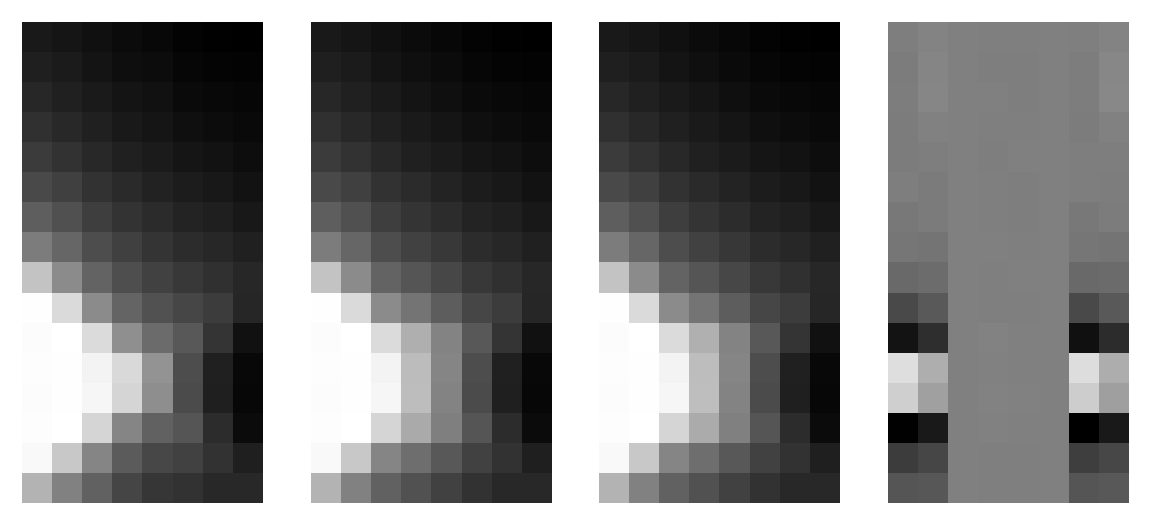

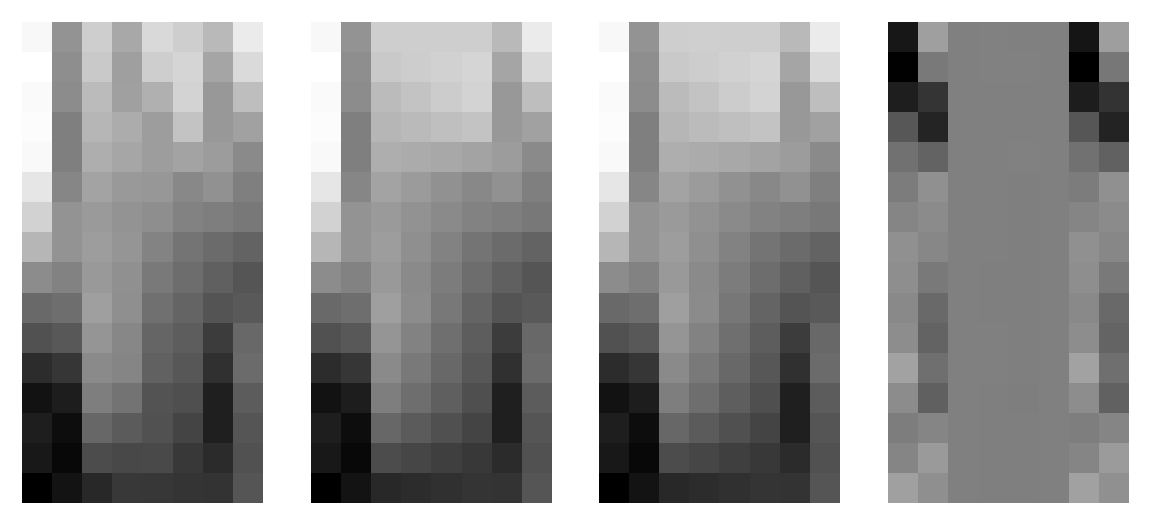

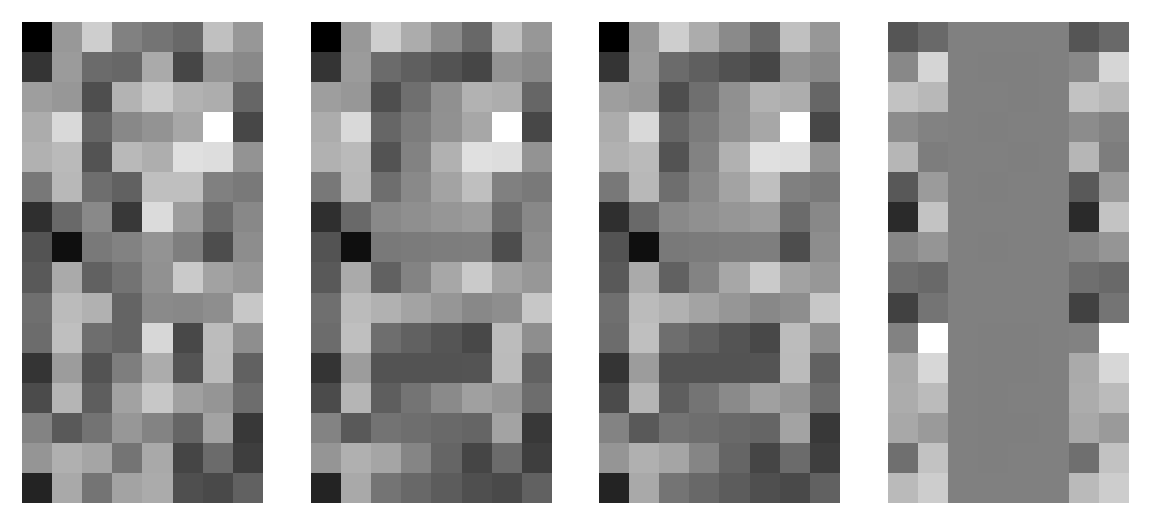

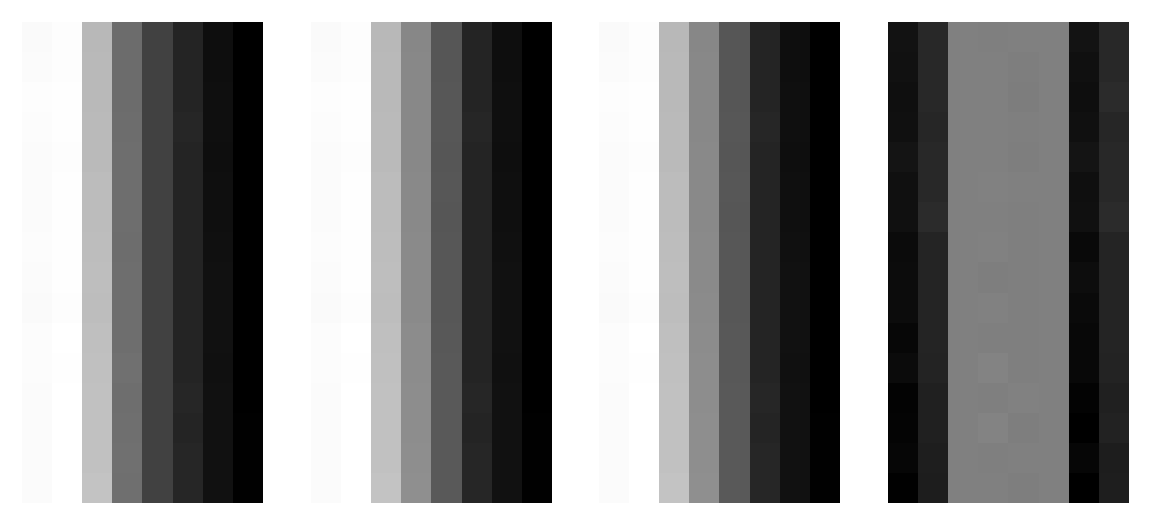

In [10]:
sg.generator.eval()
_ = sg.displayImages()
#_ = sg.summarizeMe(sg.testLoader, False)

## <font style="color:lightblue">Execute</font>

Epoch: 1 (0).  Images: 4096. DIS: 0.000e+00, GEN: 3.820e+00. Probs: True 0.000e+00, Fake 0.000e+00.
Individual losses: MSE: 3.820e+00  MSEN: 1.892e+00  L1L: 2.867e+00  L1LN: 1.562e+00  SSIM: 1.934e+00  MSSSIM: 5.174e+00  STD: 2.161e+00  COR: 1.977e+00  HIST: 9.097e-01 



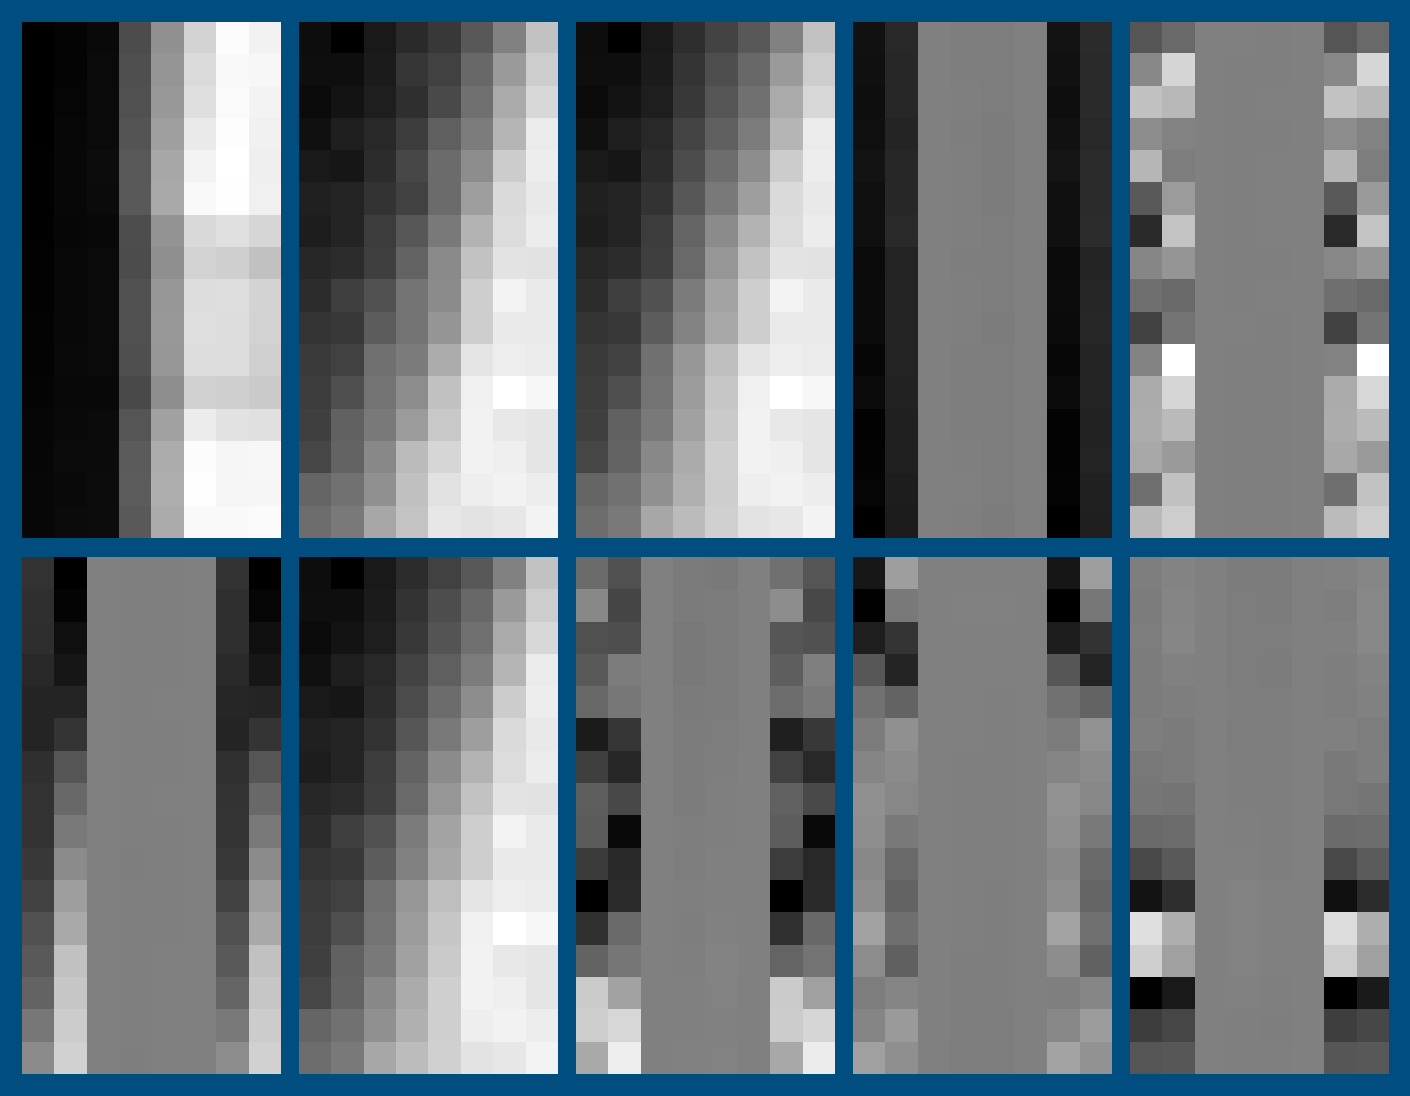

  1%|          | 84/12771 [00:55<1:59:05,  1.78it/s]

In [ ]:


sg.scheduler_G.gamma = 1-0.05
def my_beforeReport(sglocals) :
    message = ""

    message += "G" + sg.adjustScheduler(sg.scheduler_G, sg.TCfg.learningRateG, 0.001)
    sg.writer.add_scalars("Aux", {'LrnRate': sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG}, sg.imer)

    #for metrics in ('L1L','SSIM','MSSSIM') :
    #    sg.metrices[metrics].weight = max(0, sg.metrices[metrics].weight - 0.005)
    #    message += f"{metrics} weight: {sg.metrices[metrics].weight}. "
    #    sg.writer.add_scalars("Aux", {metrics: sg.metrices[metrics].weight}, sg.imer)

    print(message)
    return
#sg.beforeReport = my_beforeReport

def my_beforeEachEpoch(sglocals) :
    sg.TCfg.batchSize = min(2**10, sg.TCfg.batchSize * 2)
    sg.TCfg.batchSplit = max(2**0, int(sg.TCfg.batchSize / 2**5))
    sg.writer.add_scalars("Aux", {'Batch size': math.log(sg.TCfg.batchSize,2)}, sg.imer)
    print(f"Batch size: {sg.TCfg.batchSize}, split: {sg.TCfg.batchSplit}", )
    return
#sg.beforeEachEpoch = my_beforeEachEpoch

#sg.TCfg.num_workers=0
try :
    sg.train(savedCheckPoint)
except :
    #del sg.dataLoader
    #del sg.testLoaderhuiVam
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise



# loss MSE raw, BS=2**8, LR=1e-3


## <font style="color:lightblue">Post</font>

In [ ]:
sg.saveCheckPoint(savedCheckPoint+".pth",
                           sg.epoch+1, sg.imer, sg.minGEpoch, sg.minGLoss,
                           sg.generator, sg.discriminator,
                           sg.optimizer_G, sg.optimizer_D)


In [ ]:
for key in sg.resAcc.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices_per_epoch", {key : sg.resAcc.metrices[key],}, sg.epoch )

resTest = sg.summarizeMe(sg.testLoader, False)
resTest *= 1/resTest.nofIm
sg.writer.add_scalars("Losses epoch test",
                   {'Dis': resTest.lossD
                   ,'Gen': resTest.lossG
                   #,'Adv' : resTest.metrices['Adv']
                   }, sg.epoch )
for key in resTest.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices epoch test", {key : resTest.metrices[key],}, sg.epoch )
sg.writer.add_scalars("Probs epoch test",
                   {'Ref':resTest.predReal
                   ,'Gen':resTest.predFake
                   #,'Pre':trainRes.predGen
                   }, sg.epoch )





In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.save_model(generator, "dbricks2.pt")